In [79]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf

warnings.filterwarnings("ignore")

ff15_model = pdr.get_data_famafrench(
    'F-F_Research_Data_5_Factors_2x3_daily',
    start='2004-02-02'
)
c97_model = pdr.get_data_famafrench(
    'F-F_Momentum_Factor_daily',
    start='2004-02-02'
)
data = pd.concat(
    [ff15_model[0], c97_model[0]],
    axis=1
)

price = yf.download(
    'XOM',
    #'CVX',
    start='2004-01-30',
    end='2024-09-01',
    progress=False
)

In [80]:
ret = price['Adj Close'].pct_change().dropna()
ret.name = 'return'
data = data * 0.01
excess_return = ret - data['RF']
excess_return.name = 'excess_return'
data.drop(['RF'], axis=1, inplace=True)
data.columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

In [81]:
oil_factor = pd.read_parquet('../Data/oil_factor.parquet')

In [82]:
irx_factor = pd.read_parquet('../Data/IRX_Factor.parquet')
dyx_factor = pd.read_parquet('../Data/DYX_Factor.parquet')

In [83]:
data = pd.concat(
    [data, oil_factor.loc['2004-01-30':], irx_factor.loc['2004-01-30':], dyx_factor.loc['2004-01-30':]],
    axis = 1
)

In [84]:
data.columns = ['Mkt-RF','SMB','HML','RMW','CMA','MOM','OIL','IRX','DYX']

In [85]:
data = data.loc['2004-02':'2024-08']

In [86]:
excess_return = excess_return.loc['2004-02':'2024-08']

In [88]:
data

,Mkt-RF,SMB,HML,RMW,CMA,MOM,OIL,IRX,DYX
Date,,,,,,,,,
2004-02-02,0.0027,-0.0035,-0.0014,0.0023,-0.0028,-0.0055,-0.000355,-0.000551,-0.000538
2004-02-03,0.0000,-0.0013,-0.0004,0.0020,-0.0015,0.0002,0.000648,0.000543,0.000545
2004-02-04,-0.0097,-0.0145,-0.0059,0.0158,-0.0115,-0.0151,-0.004654,-0.004564,-0.004582
2004-02-05,0.0023,0.0045,0.0018,-0.0020,0.0014,0.0015,0.007936,0.008089,0.008120
2004-02-06,0.0139,0.0103,0.0041,-0.0090,0.0090,0.0162,0.009140,0.009101,0.009137
...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.0034,0.0033,0.0017,0.0013,-0.0006,-0.0045,0.000645,0.000579,0.000579
2024-08-27,0.0005,-0.0090,0.0002,0.0027,0.0023,0.0053,0.004886,0.004849,0.004849
2024-08-28,-0.0067,-0.0022,0.0114,0.0055,-0.0016,0.0030,0.008561,0.008541,0.008541


### Modeling

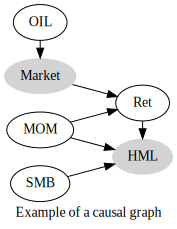

In [89]:
import graphviz as gr

chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Example of a causal graph'
    }
)

chain.edge('Market', 'Ret')
chain.edge('MOM', 'Ret')
chain.edge('MOM', 'HML')
chain.edge('SMB', 'HML')
chain.edge('Ret', 'HML')
chain.edge('OIL', 'Market')

chain.node(
    'HML', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)
chain.node(
    'Market', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Ret')
    s.node('HML')
with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Market')
    s.node('OIL')
    s.node('MOM')

chain

In [90]:
import statsmodels.api as sm

X = sm.add_constant(
    data
)
ols2 = sm.OLS(excess_return, X).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     584.2
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:33:55   Log-Likelihood:                 15711.
No. Observations:                5181   AIC:                        -3.140e+04
Df Residuals:                    5171   BIC:                        -3.134e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.937e-05      0.000     -0.234      0.8

In [93]:
X = sm.add_constant(
    data[['DYX','IRX','OIL']]
)
treatment = sm.OLS(data['Mkt-RF'], X).fit()
print(treatment.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.006
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           0.000106
Time:                        22:34:30   Log-Likelihood:                 15532.
No. Observations:                5181   AIC:                        -3.106e+04
Df Residuals:                    5177   BIC:                        -3.103e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.704      0.0

In [94]:
mkt_hat = treatment.resid
mkt_hat.name = 'Mkt_hat'

### HML Factor

In [95]:
T = sm.add_constant(
    data[['MOM', 'SMB']]
)
y_t = data['HML']
ols0 = sm.OLS(y_t, T).fit()
print(ols0.summary())  # true positive based causal graph
hml_hat = ols0.resid
hml_hat.name = 'HML_hat'

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     646.8
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          1.79e-251
Time:                        22:34:51   Log-Likelihood:                 18316.
No. Observations:                5181   AIC:                        -3.663e+04
Df Residuals:                    5178   BIC:                        -3.661e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.973e-06    9.8e-05      0.030      0.9

### Causal Model

In [96]:
X = sm.add_constant(
    pd.concat(
        [data[['MOM','OIL']], hml_hat],
        axis = 1
    )
)

In [97]:
ols = sm.OLS(excess_return, X).fit()

In [98]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     218.5
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          1.74e-133
Time:                        22:34:55   Log-Likelihood:                 14203.
No. Observations:                5181   AIC:                        -2.840e+04
Df Residuals:                    5177   BIC:                        -2.837e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.720      0.0

$$\text{XOM}_t - R_f= -0.3429 \text{MOM}_t + 0.0643 \text{OIL}_t + 0.6086 \nu_t + \varepsilon_t$$
$$R_m - R_f = 0.0006 - 0.0381 \text{OIL}_t + u_t$$
$$\text{HML}_t = -0.3072 \text{MOM}_t + 0.1588 \text{SMB}_t + \nu_t$$

### Future Works

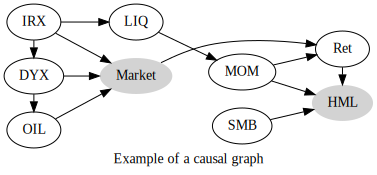

In [99]:
import graphviz as gr

chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Example of a causal graph'
    }
)

chain.edge('Market', 'Ret')
chain.edge('MOM', 'Ret')
chain.edge('MOM', 'HML')
chain.edge('SMB', 'HML')
chain.edge('Ret', 'HML')
chain.edge('OIL', 'Market')
chain.edge('IRX', 'Market')
chain.edge('DYX', 'Market')
chain.edge('DYX', 'OIL')
chain.edge('IRX', 'DYX')
chain.edge('IRX', 'LIQ')
chain.edge('LIQ', 'MOM')

chain.node(
    'HML', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)
chain.node(
    'Market', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Ret')
    s.node('HML')
with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('OIL')
    s.node('IRX')
    s.node('DYX')

chain